<a href="https://colab.research.google.com/github/i-shah/livertox-crt-2015/blob/master/LivTox_CRT_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Hepatotoxicity Using ToxCast in Vitro Bioactivity and Chemical Structure

Attempting this analysis in Google CoLab

http://pubs.acs.org/doi/abs/10.1021/tx500501h

# Reproducing the results shown in Table 2


The following notebook provides step-by-step instructions for reproducing the results shown in Table 2 of [J. Liu, K. Mansouri, R. S. Judson, M. T. Martin, H. Hong, M. Chen, X. Xu, R. S. Thomas, and I. Shah, “Predicting hepatotoxicity using ToxCast in vitro bioactivity and chemical structure,” Chem. Res. Toxicol., vol. 28, no. 4, pp. 738–751, Apr. 2015](http://pubs.acs.org/doi/abs/10.1021/tx500501h). 



## Print out some useful information about your system

In [0]:

import platform,sys

print("""Python version: %s
dist: %s
system: %s
machine: %s
platform: %s
version: %s
""" % (
    sys.version.split('\n'),
    str(platform.dist()),
    platform.system(),
    platform.machine(),
    platform.platform(),
    platform.version()
))

Python version: ['3.6.9 (default, Nov  7 2019, 10:44:02) ', '[GCC 8.3.0]']
dist: ('Ubuntu', '18.04', 'bionic')
system: Linux
machine: x86_64
platform: Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
version: #1 SMP Thu Aug 8 02:47:02 PDT 2019



## Load all the required packages

In [0]:
import numpy as np
import pylab as pl
import pandas as pd

from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import precision_score,recall_score,accuracy_score
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import StratifiedKFold,train_test_split

from time import time
import warnings
warnings.simplefilter('ignore')
import os
import subprocess
import warnings

import pandas as pd
import re
import bz2
import pdb

## Set up anyvariables and functions used by the analysis

In [0]:
# Store all classifiers in a dictionary
Classifiers1 = dict(LDA = LDA(),
                    NB= GaussianNB(), 
                    KNN1=KNeighborsClassifier(algorithm='auto',n_neighbors=3), 
                    SVCL0=SVC(kernel='linear'), 
                    SVCR0=SVC(C=1.0, cache_size=400, class_weight=None, coef0=0.0, degree=3,
                              gamma=10.0, kernel='rbf', max_iter=-1, probability=False, shrinking=True,
                              tol=0.0001, verbose=False),
                    CART0=DecisionTreeClassifier(max_depth=10))

DataSet = {}
Markers = {}


def selFeatsFilter(A,b,top=5):
    selector = SelectPercentile(f_classif, percentile=10)
    selector.fit(A, b)
    scores = -np.log10(selector.pvalues_)
    scores[np.isnan(scores)]=0
    np.argsort(scores)
    if top>len(scores): top=len(scores)
    return np.argsort(scores)[-top:]

def myScore(Y_test,Y_pred):
    X = dict(TP=np.sum(np.logical_and(Y_pred==1, Y_test==1)),
             TN=np.sum(np.logical_and(Y_pred==0, Y_test==0)),
             FP=np.sum(np.logical_and(Y_pred==1, Y_test==0)),
             FN=np.sum(np.logical_and(Y_pred==0, Y_test==1)))
    for i,v in X.items(): v *= 1.0
    TP,TN,FP,FN = X['TP'],X['TN'],X['FP'],X['FN']
    return dict(cm=X,acc=1.0*(TP+TN)/(TP+TN+FP+FN),sens=1.0*TP/(TP+FN),spec=1.0*TN/(TN+FP))

def countPosNeg(X):
    n0=np.sum(X==0)
    n1=np.sum(X==1)
    if n1>n0: 
        return 1
    else:
        return 0

def trainAndTestClassifiers(X,Y,I_test,I_train,n_desc,dbg=False,
                            TOPD=Markers,CLSF=Classifiers1):
    X_test = X.ix[I_test,:]
    X_train = X.ix[I_train,:]
    Y_test = Y.ix[I_test]
    Y_train = Y.ix[I_train]
    F_best = selFeatsFilter(X_train,Y_train,n_desc)
    Perf_i   =[]
    Vote   =pd.DataFrame(np.zeros((len(I_test),len(CLSF))),columns=CLSF.keys())
    
    if dbg: print("Train",X_train.shape," Test",X_test.shape," n_desc",len(F_best))
    for nm,clf in CLSF.items():
        if dbg: print(nm)
        try:
            if dbg: print(" Training")
            clf.fit(X_train.ix[:,F_best], Y_train)
            if dbg: print(" Testing")
            Y_pred = clf.predict(X_test.ix[:,F_best])
            Vote[nm]=Y_pred
            if dbg: print(" Calc score")
            P_i = myScore(Y_test,Y_pred)
            if dbg: print(" Make results")
            P = dict(cl=nm,sens=P_i['sens'],spec=P_i['spec'],
                     bacc=0.5*(P_i['sens']+P_i['spec']),
                     prec=precision_score(Y_test,Y_pred),
                     n_pos=np.sum(Y_train==1),n_neg=np.sum(Y_train==0),
                     n_desc=n_desc,
                     acc=accuracy_score(Y_test,Y_pred))
                
            Perf_i.append(P)
                             
        except:
            print("   %s Failed!" % nm)

    # Now get the majority vote for the class
    if dbg: print(" Ensemble")
    #pdb.set_trace()
    Y_pred=Vote.apply(countPosNeg,axis=1)
    P_i = myScore(Y_test.array,Y_pred)

    P = dict(cl='ENSMB',sens=P_i['sens'],spec=P_i['spec'],
             bacc=0.5*(P_i['sens']+P_i['spec']),
             prec=precision_score(Y_test,Y_pred),
             n_pos=np.sum(Y_train==1),n_neg=np.sum(Y_train==0),
             n_desc=n_desc,
             acc=accuracy_score(Y_test,Y_pred))
    Perf_i.append(P)

    if dbg: print(" Done")

    return pd.DataFrame(Perf_i)


def resampleBalCVLearn(n_pos,n_neg,trial=1,
                       n_desc_min=5,n_desc_max=70,n_desc_step=5,
                       K=10,DS=DataSet,TOPD=Markers,
                       CLSF=Classifiers1,dbg=False):
    """
    Creates a balanced undersampled subset of the data for K-fold CV testing n_reps times 
    Requires: DS (which is pushed by dview)

    """
    Data = DS['Data']
    Y_pos = Data[DS['pos_cls']]
    X_pos = Data[DS['Desc']].ix[Y_pos==1,:]
    N_pos = np.sum(Y_pos[Y_pos==1])
    
    Y_neg = Data[DS['neg_cls']]
    X_neg = Data[DS['Desc']].ix[Y_neg==1,:]
    N_neg = np.sum(Y_neg[Y_neg==1])

    I_pos = np.random.randint(0,N_pos,n_pos)
    X_pi = X_pos.ix[I_pos,:]
    X_pi['out']=1

    I_neg = np.random.randint(0,N_neg,n_neg)
    X_ni = X_neg.ix[I_neg,:]
    X_ni['out']=0

    X = pd.concat((X_pi,X_ni))
    Y = X['out']
    X = X.drop('out',axis=1)
    
    Perf_cv = []
    
    #pid=os.getpid()

    SKF = StratifiedKFold(n_splits=K)

    i_step = 0
    for n_desc in range(n_desc_min,n_desc_max,n_desc_step):
        for I_train,I_test in SKF.split(X,Y):
            i_step += 1
            if dbg: print('Data',X.shape)
            P_df=trainAndTestClassifiers(X,Y,I_test,I_train,n_desc,
                                         TOPD=Markers,CLSF=Classifiers1,dbg=dbg)
            P_df['n_obs']=n_pos+n_neg
            P_df['n_pos']=n_pos
            P_df['n_neg']=n_neg
            P_df['dtp'] = DS['dtp']
            P_df['tox'] = DS['tox']
            P_df['cvk'] = K
            P_df['itrl']= "%d-%d" % (trial,i_step)
            Perf_cv += P_df.T.to_dict().values()
        
    return Perf_cv

# The rest is just to make a summary table of performance results from all the replicates

C1=pd.MultiIndex.from_tuples(
[('n_desc', 'bio'),
 ('n_desc', 'chm'),
 ('n_desc', 'bc'),
 ('bacc', 'bio'),
 ('bacc', 'chm'),
 ('bacc', 'bc'),
 ('sens', 'bio'),
 ('sens', 'chm'),
 ('sens', 'bc'),
 ('spec', 'bio'),
 ('spec', 'chm'),
 ('spec', 'bc')])
ii_tox=0
ii_dtp=1
ii_cl =2
ii_cvk=3
ii_nds=4
ii_nob=5


def buildMSTable1(P_st,cols=C1):
    X= P_st.groupby(level=['tox','dtp','cl']).max()
    Tox=set([i[0] for i in X.index])
    Dtp=set([i[1] for i in X.index])
    CL =set([i[2] for i in X.index])
    Res=[]
    for tox in Tox:
        for dtp in Dtp:
            for cl in CL:
                Bacc=X.xs((tox,dtp,cl))['bacc']
                Y = P_st.xs((tox,dtp,cl)).reset_index()[['n_desc','bacc']]
                Y1 = Y[(Y['bacc']==Bacc)].n_desc
                Res.append(dict(tox=tox,dtp=dtp,cl=cl,n_desc=int(list(Y1)[0])))
    Res_df = pd.DataFrame(Res).set_index(['tox','dtp','cl'])
    X = pd.merge(X,Res_df,left_index=True,right_index=True)
    #X['bacc2'] = X.apply(lambda x: "%3.2f(%d)"%(x[1],x[-1]),axis=1)

    T1 = np.round(pd.pivot_table(X.reset_index(),index=['tox','cl'],columns=['dtp'],values=['bacc','n_desc','sens','spec']),decimals=2)
    return T1[cols]

def buildMSTable2(P_mn,P_sd,cols=C1):
    IMB_mn = buildMSTable1(P_mn)
    IMB_sd = buildMSTable1(P_sd)

    if len(cols)>0: 
        C1 = cols 
    else:
        C1 = IMB_mn.columns
        
    R1=IMB_mn.index
    IMB_res = pd.DataFrame(columns=C1,index=R1)

    for i in [x for x in C1 if x[0]=='n_desc']:
        IMB_res[i] = IMB_mn[i]

    for r in R1:
        for c in [c for c in C1 if c[0]!='n_desc']:
            IMB_res.ix[r,c] = "%3.2f (%3.2f)" % (IMB_mn.ix[r,c],IMB_sd.ix[r,c]) 

    return IMB_res

def buildMSTable11(P_st,cols=C1):
    X= P_st.groupby(level=['tox','dtp']).max()
    Tox=set([i[0] for i in X.index])
    Dtp=set([i[1] for i in X.index])
    Res=[]
    for tox in Tox:
        for dtp in Dtp:
            Bacc=X.xs((tox,dtp))['bacc']
            Y = P_st.xs((tox,dtp)).reset_index()[['n_desc','bacc']]
            Y1 = Y[(Y['bacc']==Bacc)].n_desc
            #print tox,dtp,cl,Bacc,int(Y1)
            Res.append(dict(tox=tox,dtp=dtp,n_desc=int(list(Y1)[0])))
    Res_df = pd.DataFrame(Res).set_index(['tox','dtp'])
    X = pd.merge(X,Res_df,left_index=True,right_index=True)
    #X['bacc2'] = X.apply(lambda x: "%3.2f(%d)"%(x[1],x[-1]),axis=1)

    T1 = np.round(pd.pivot_table(X.reset_index(),index=['tox'],columns=['dtp'],values=['bacc','n_desc','sens','spec']),decimals=2)
    return T1[cols]

def buildMSTable21(P_mn,P_sd,cols=C1):
    IMB_mn = buildMSTable11(P_mn)
    IMB_sd = buildMSTable11(P_sd)

    if len(cols)>0: 
        C1 = cols 
    else:
        C1 = IMB_mn.columns
    
    R1=IMB_mn.index
    IMB_res = pd.DataFrame(columns=C1,index=R1)

    for i in [x for x in C1 if x[0]=='n_desc']:
        IMB_res[i] = IMB_mn[i]

    for r in R1:
        for c in [c for c in C1 if c[0]!='n_desc']:
            IMB_res.ix[r,c] = "%3.2f (%3.2f)" % (IMB_mn.ix[r,c],IMB_sd.ix[r,c]) 

    return IMB_res



## Load the data files and format the data sets

In [7]:
!git clone https://github.com/i-shah/livertox-crt-2015.git /tmp

Cloning into '/tmp'...
remote: Enumerating objects: 43, done.
remote: Total 43 (delta 0), reused 0 (delta 0), pack-reused 43
Unpacking objects: 100% (43/43), done.


In [9]:
!ls /tmp/data/

liv-tox-pred-1.csv.bz2


In [0]:
# The data file integrates chm, bio and tox data
import bz2
DF = pd.read_csv("/tmp/data/liv-tox-pred-1.csv.bz2",compression='infer')
DF1 = DF.set_index(['cid','CASRN','name'])

In [13]:
#Figure out the columns for each descriptor
#print DF1.columns
Col_tox = ['Hypertrophy', 'Injury', 'Proliferative.lesions', 'No.liver.lesions']
Col_bio = [i for i in DF1.columns if re.search(r'^APR|^ATG|^ACEA|^NVS|^OT|^Tox21',i,re.I)]
Col_chm = [i for i in DF1.columns if i not in Col_tox+Col_bio]

print("Tox",len(Col_tox)," Bio",len(Col_bio)," Chm",len(Col_chm))

# Now create the different datasets for ML
#
# DataSet:
#   Desc: list of descriptors
#   pos_cls: name of positive class
#   neg_cls: name of negative class
#   dtp: descriptor type bio|chm|bc
#   Data: DataFrame containing all data
#   title: string name for the data set

ML1 = dict()
ML1['Inj-bio']=dict(Desc=Col_bio,pos_cls='Injury',neg_cls='No.liver.lesions',dtp='bio',
                Data=DF1,
                title="Liver Injury ~ Bioactivity")

ML1['Hyp-bio']=dict(Desc=Col_bio,pos_cls='Hypertrophy',neg_cls='No.liver.lesions',dtp='bio',
                Data=DF1,
                title="Liver Hypertrophy ~ Bioactivity")

ML1['Pro-bio']=dict(Desc=Col_bio,pos_cls='Proliferative.lesions',neg_cls='No.liver.lesions',dtp='bio',
                Data=DF1,
                title="Liver Proliferative Lesions ~ Bioactivity")

ML1['Inj-chm']=dict(Desc=Col_chm,pos_cls='Injury',neg_cls='No.liver.lesions',dtp='chm',
                Data=DF1,
                title="Liver Injury ~ Chem")

ML1['Hyp-chm']=dict(Desc=Col_chm,pos_cls='Hypertrophy',neg_cls='No.liver.lesions',dtp='chm',
                Data=DF1,
                title="Liver Hypertrophy ~ Chem")

ML1['Pro-chm']=dict(Desc=Col_chm,pos_cls='Proliferative.lesions',neg_cls='No.liver.lesions',dtp='chm',
                Data=DF1,
                title="Liver Proliferative Lesions ~ Chem")

ML1['Inj-bc']=dict(Desc=Col_chm+Col_bio,pos_cls='Injury',neg_cls='No.liver.lesions',dtp='bc',
                Data=DF1,
                title="Liver Injury ~ Bio + Chem")

ML1['Hyp-bc']=dict(Desc=Col_chm+Col_bio,pos_cls='Hypertrophy',neg_cls='No.liver.lesions',dtp='bc',
                Data=DF1,
                title="Liver Hypertrophy ~ Bio + Chem")

ML1['Pro-bc']=dict(Desc=Col_chm+Col_bio,pos_cls='Proliferative.lesions',neg_cls='No.liver.lesions',dtp='bc',
                Data=DF1,
                title="Liver Proliferative Lesions ~ Bio + Chem")

for tox,V in ML1.items():
    V['tox']=tox.split('-')[0]
    


Tox 4  Bio 127  Chm 730


In [15]:
for tox,DS in ML1.items():
    Data = DS['Data']
    pos  = DS['pos_cls']
    neg  = DS['neg_cls']
    
    print(tox,np.sum(Data[pos]==1),np.sum(Data[neg]==1))


Inj-bio 101 463
Hyp-bio 161 463
Pro-bio 99 463
Inj-chm 101 463
Hyp-chm 161 463
Pro-chm 99 463
Inj-bc 101 463
Hyp-bc 161 463
Pro-bc 99 463


## Run the machine learning analysis

In [54]:
import sys, time
sys.stdout.flush()
    
PERF   = []
TOPDESC={}
i_trl = 0
for tox in ['Hyp-chm','Hyp-bio','Hyp-bc',
            'Inj-chm','Inj-bio','Inj-bc',
            'Pro-chm','Pro-bio','Pro-bc',
            ]:
    DS = ML1[tox]
    Markers = {}
    Res = []
    print("\n>>", DS['title'],len(PERF),time.strftime("%d/%m/%Y %H:%M",time.localtime()))

    Data = DS['Data']
    Y_pos = Data[DS['pos_cls']]
    X_pos = Data[DS['Desc']].ix[Y_pos==1,:]
    N_pos = np.sum(Y_pos[Y_pos==1])
    Y_neg = Data[DS['neg_cls']]
    N_neg = np.sum(Y_neg[Y_neg==1])
    print("  >  No. of pos: %d neg: %d" % (N_pos,N_neg),time.strftime("%d/%m/%Y %H:%M",time.localtime()))
    sys.stdout.flush()
    # This runs 2 undersampled datasets  -- need at least 20
    for i in range(5):
        i_trl+=1
        print("   Trial", i_trl)
        Res += resampleBalCVLearn(n_pos=N_pos,n_neg=N_neg,trial=i_trl,
                                n_desc_min=10,n_desc_max=70,n_desc_step=5,
                                K=10,DS=DS,TOPD=Markers,CLSF=Classifiers1,dbg=False)

    PERF += Res
    TOPDESC[tox]=Markers


print("> ML analysis done ",time.strftime("%d/%m/%Y %H:%M",time.localtime()))

PERF1_df = pd.DataFrame(PERF)
PERF1_df.set_index(['tox','dtp','cl','itrl','cvk','n_desc','n_pos','n_neg','n_obs'],inplace=True)
# These are variables used further below
TOP_DESC1=TOPDESC


>> Liver Hypertrophy ~ Chem 0 13/02/2020 15:36
  >  No. of pos: 161 neg: 463 13/02/2020 15:36
   Trial 1
   Trial 2
   Trial 3
   Trial 4
   Trial 5

>> Liver Hypertrophy ~ Bioactivity 4200 13/02/2020 15:38
  >  No. of pos: 161 neg: 463 13/02/2020 15:38
   Trial 6
   Trial 7
   Trial 8
   Trial 9
   Trial 10

>> Liver Hypertrophy ~ Bio + Chem 8400 13/02/2020 15:40
  >  No. of pos: 161 neg: 463 13/02/2020 15:40
   Trial 11
   Trial 12
   Trial 13
   Trial 14
   Trial 15

>> Liver Injury ~ Chem 12600 13/02/2020 15:42
  >  No. of pos: 101 neg: 463 13/02/2020 15:42
   Trial 16
   Trial 17
   Trial 18
   Trial 19
   Trial 20

>> Liver Injury ~ Bioactivity 16800 13/02/2020 15:43
  >  No. of pos: 101 neg: 463 13/02/2020 15:43
   Trial 21
   Trial 22
   Trial 23
   Trial 24
   Trial 25

>> Liver Injury ~ Bio + Chem 21000 13/02/2020 15:45
  >  No. of pos: 101 neg: 463 13/02/2020 15:45
   Trial 26
   Trial 27
   Trial 28
   Trial 29
   Trial 30

>> Liver Proliferative Lesions ~ Chem 25200 13/02

In [0]:
PERF1_df.to_csv("/tmp/perf-imbalanced-rep-20.tsv")

In [0]:
P2_mn = PERF1_df.groupby(level=['tox','dtp','cl','cvk','n_desc','n_obs']).mean()
P2_sd = PERF1_df.groupby(level=['tox','dtp','cl','cvk','n_desc','n_obs']).std()


In [0]:
# FInd the rows containing the max number of examples
X = P2_mn.reset_index()
N_obs=X[['tox','n_obs']].groupby('tox').max().to_dict()['n_obs']
Y = []
for tox,n_obs in N_obs.items():
    X1 = X[(X['tox']==tox) & (X['n_obs']==n_obs)]
    Y += [X1.iloc[i].to_dict() for i in range(X1.shape[0])]
P21_mn = pd.DataFrame(Y)
P21_mn.set_index(['tox','dtp','cl','cvk','n_desc','n_obs'],inplace=True)
P21_mn = P21_mn.groupby(level=['tox','dtp','cl','cvk','n_desc','n_obs']).mean()

X = P2_sd.reset_index()
Y = []
for tox,n_obs in N_obs.items():
    X1 = X[(X['tox']==tox) & (X['n_obs']==n_obs)]
    Y += [X1.iloc[i].to_dict() for i in range(X1.shape[0])]
P21_sd = pd.DataFrame(Y).set_index(['tox','dtp','cl','cvk','n_desc','n_obs'])
P21_sd = P21_sd.groupby(level=['tox','dtp','cl','cvk','n_desc','n_obs']).mean()


In [58]:
Table5 = buildMSTable2(P21_mn,P21_sd)
Table5


n_desc          ...         spec                          
             bio chm  bc  ...          bio          chm           bc
tox cl                    ...                                       
Hyp CART0     65  65  60  ...  0.96 (0.03)  0.93 (0.05)  0.96 (0.04)
    ENSMB     65  60  65  ...  0.98 (0.03)  0.96 (0.05)  0.98 (0.04)
    KNN1      15  55  35  ...  0.92 (0.14)  0.91 (0.16)  0.92 (0.13)
    LDA       60  60  60  ...  0.96 (0.04)  0.91 (0.06)  0.96 (0.05)
    NB        60  65  65  ...  0.91 (0.13)  0.87 (0.08)  0.87 (0.06)
    SVCL0     65  65  65  ...  0.96 (0.04)  0.91 (0.06)  0.95 (0.06)
    SVCR0     65  65  30  ...  1.00 (0.04)  0.99 (0.05)  0.99 (0.05)
Inj CART0     65  55  45  ...  0.97 (0.03)  0.95 (0.06)  0.98 (0.04)
    ENSMB     65  65  65  ...  0.99 (0.02)  0.98 (0.06)  0.99 (0.03)
    KNN1      25  40  50  ...  0.96 (0.12)  0.95 (0.07)  0.95 (0.09)
    LDA       65  65  65  ...  0.97 (0.04)  0.95 (0.05)  0.97 (0.04)
    NB        10  40  35  ...  0.92 (0.19)  0.87 (0.17)  0.86 (0.20)
    SVCL0     60  65  65  ...  0.98 (0.02)  0.96 (0.06)  0.98 (0.03)
    SVCR0     65  65  65  ...  1.00 (0.02)  0.99 (0.06)  1.00 (0.02)
Pro CART0     65  65  65  ...  0.97 (0.03)  0.98 (0.04)  0.97 (0.04)
    ENSMB     65  65  65  ...  0.99 (0.02)  0.98 (0.05)  0.99 (0.04)
    KNN1      65  50  50  ...  0.96 (0.16)  0.92 (0.19)  0.94 (0.07)
    LDA       55  50  60  ...  0.97 (0.04)  0.94 (0.05)  0.96 (0.05)
    NB        20  45  65  ...  0.90 (0.32)  0.84 (0.14)  0.86 (0.12)
    SVCL0     65  65  65  ...  0.98 (0.03)  0.99 (0.04)  0.98 (0.04)
    SVCR0     65  65  65  ...  1.00 (0.02)  0.98 (0.04)  0.99 (0.04)

[21 rows x 12 columns]

## Compare the above with the published Table 2


In [0]:
from PIL import Image
from io import BytesIO
import requests
# This url may be different so may need to double-check online
x = requests.get('https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/crtoec/2015/crtoec.2015.28.issue-4/tx500501h/20150414/images/medium/tx-2014-00501h_0009.gif')
Table_img = Image.open(BytesIO(x.content))


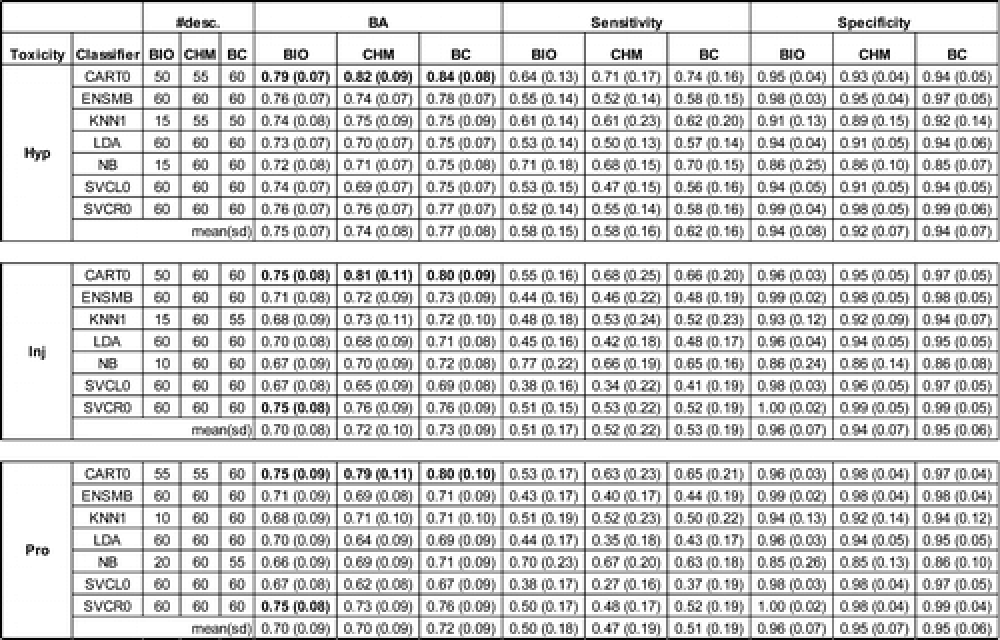

In [63]:
Table_img.resize((1000,640))